# House Price Prediction Comparison (Revised)

This notebook implements three versions of a neural network to predict house prices using:
- **Keras/TensorFlow**
- **PyTorch**
- **JAX (Flax & Optax)**

We use **log-transformed** targets (`SalePrice`) during training to stabilize the dynamic range, and then exponentiate predictions for evaluation. We also combine **MSE** (mean squared error on log values) with a **KL divergence** penalty computed from differentiable soft histograms. The goal is to encourage the model’s predicted distribution to match the actual distribution.

### Key Changes in This Revision
1. **Lower alpha** (KL weight) to `1e-4` in **all** frameworks.
2. **Bin Range** for the histogram is based on both `y_true` and `y_pred` to avoid ignoring extremely large predictions.
3. **Reduced Learning Rate** for PyTorch and JAX to `1e-4` for more stable training.
4. **Explanatory Markdown** on how the MSE + KL divergence formula is computed.

By aligning these settings, we aim to reduce the huge RMSE discrepancies seen previously in PyTorch and JAX.

## Mathematical Explanation of MSE + KL Divergence

**Mean Squared Error (MSE)** on log-scale targets:
$$
  \text{MSE} = \frac{1}{N}\sum_{i=1}^{N} (y_{\text{true}, i} - y_{\text{pred}, i})^2,
$$
where $$y_{\text{true}}$$ and $$y_{\text{pred}}$$ are the log-transformed values of SalePrice.

**KL Divergence** is computed between the soft histograms of $$y_{\text{true}}$$ and $$y_{\text{pred}}$$. If $$P$$ and $$Q$$ are discrete distributions (here, histograms), then:
$$
  D_{KL}(P\Vert Q) = \sum_{j} P_j \log\left(\frac{P_j}{Q_j}\right).
$$
We create a soft histogram by convolving each log-price value with a Gaussian kernel of width $$\sigma$$. The bin range is determined by the minimum and maximum of **both** $$y_{\text{true}}$$ and $$y_{\text{pred}}$$ to avoid ignoring extreme values. We then clip these histogram values by a small epsilon to avoid taking the log of zero.

Finally, the **combined loss** is:
$$
  \text{Loss} = \text{MSE} + \alpha\, D_{KL}(P\Vert Q),
$$
where $$\alpha\$$ is a small weight (1e-4) to ensure KL does not overwhelm MSE.

In [15]:
pip install tensorflow pytorch jax flax

/usr/local/python/3.12.1/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [6 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-zjx00o2s/pytorch_055a70f988c94b3d89706f77e5a3f948/setup.py", line 15, in <module>
          raise Exception(message)
      Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
ERROR: ERROR: Failed to build installable whe

In [16]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# JAX / Flax / Optax
import jax
import jax.numpy as jnp
import flax.linen as nn_flax
from flax.training import train_state
import optax

print('TensorFlow version:', tf.__version__)
print('Torch version:', torch.__version__)
print('JAX version:', jax.__version__)

%matplotlib inline

TensorFlow version: 2.18.0
Torch version: 2.5.1+cpu
JAX version: 0.5.0


## 1. Load and Preprocess Data

Update the file paths below to point to your `train.csv` and `test.csv` files.

In [17]:
# Update these paths as needed
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print('Train shape:', train_df.shape)
print('Test shape:', test_df.shape)

Train shape: (1000, 81)
Test shape: (460, 80)


### 1.1 Missing Values, Log Transform, One-Hot Encoding


Processed training features shape: (1000, 230)


/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

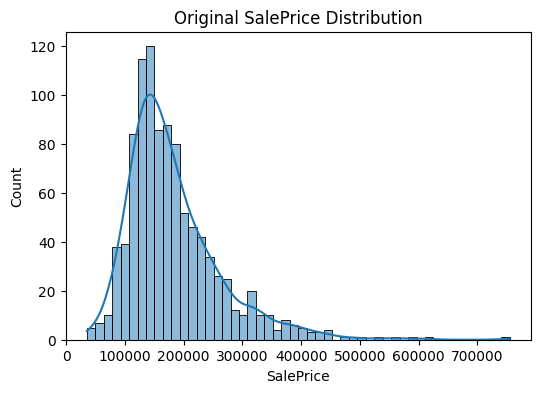

In [18]:
def fill_missing_values(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in num_cols:
        df[col].fillna(df[col].median(), inplace=True)
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    return df

train_df = fill_missing_values(train_df.copy())
train_ids = train_df['Id']
train_df.drop('Id', axis=1, inplace=True)

# Log-transform target
y = np.log(train_df['SalePrice'])
X = train_df.drop('SalePrice', axis=1)

X = pd.get_dummies(X, drop_first=True)

print('Processed training features shape:', X.shape)

# Optional: visualize original SalePrice distribution
plt.figure(figsize=(6,4))
sns.histplot(np.exp(y), bins=50, kde=True)
plt.title('Original SalePrice Distribution')
plt.xlabel('SalePrice')
plt.show()

### 1.2 Feature Selection
Keep the top five features most correlated with SalePrice.

In [19]:
numeric_df = train_df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
top_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).iloc[1:6].index.tolist()
print('Top 5 features selected:', top_features)

X = X[top_features]
print('X shape after feature selection:', X.shape)

Top 5 features selected: ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF']
X shape after feature selection: (1000, 5)


### 1.3 Train-Validation Split and Scaling

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print('X_train_scaled shape:', X_train_scaled.shape)
print('X_val_scaled shape:', X_val_scaled.shape)

X_train_scaled shape: (800, 5)
X_val_scaled shape: (200, 5)


## 2. Keras/TensorFlow

Build a feed-forward network and combine MSE with KL divergence. We unify the bin range to include both `y_true` and `y_pred` so that we capture outliers in the predicted distribution.

In [21]:
def soft_histogram_tf(x, y, num_bins=50, sigma=1.0):
    # Combine x + y to get the min/max range
    min_val = tf.reduce_min(tf.concat([x, y], axis=0))
    max_val = tf.reduce_max(tf.concat([x, y], axis=0))
    bin_centers = tf.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        diff = tf.reshape(vals, [-1,1]) - bin_centers  # (batch, num_bins)
        soft_counts = tf.exp(-tf.square(diff)/(2.0*sigma**2))
        hist = tf.reduce_sum(soft_counts, axis=0)
        hist = hist / tf.reduce_sum(hist)
        return hist

    hist_x = compute_hist(x)
    hist_y = compute_hist(y)
    return hist_x, hist_y

def kl_divergence_loss_tf(y_true, y_pred, alpha=1e-4, num_bins=50, sigma=1.0):
    hist_true, hist_pred = soft_histogram_tf(y_true, y_pred, num_bins=num_bins, sigma=sigma)
    epsilon = 1e-6
    hist_true = tf.clip_by_value(hist_true, epsilon, 1.0)
    hist_pred = tf.clip_by_value(hist_pred, epsilon, 1.0)
    kl = tf.reduce_sum(hist_true * tf.math.log(hist_true / hist_pred))
    return kl * alpha

def combined_loss_tf(y_true, y_pred):
    # MSE on log scale
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    # KL term
    kl_term = kl_divergence_loss_tf(y_true, y_pred, alpha=1e-4, num_bins=50, sigma=1.0)
    return mse + kl_term

# Build Keras model
model_keras = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_keras.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
                    loss=combined_loss_tf)
model_keras.summary()

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train Keras model
history_keras = model_keras.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    verbose=1
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 137.2667 - val_loss: 102.9537
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 87.6307 - val_loss: 44.3298
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37.8807 - val_loss: 22.2125
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.7301 - val_loss: 14.9273
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14.9970 - val_loss: 9.9552
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12.1730 - val_loss: 7.1764
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.2123 - val_loss: 5.4054
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8026 - val_loss: 4.3490
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.9229 - val_loss: 3.6620
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8301 - val_loss: 2.9521
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0321 - val_loss: 2.6083
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

### Keras Evaluation and Predictions
Exponentiate the log-scale predictions, compute RMSE, and save test predictions.

In [23]:
y_val_pred_log = model_keras.predict(X_val_scaled).flatten()
y_val_pred = np.exp(y_val_pred_log)
y_val_actual = np.exp(y_val)

rmse_keras = np.sqrt(mean_squared_error(y_val_actual, y_val_pred))
print('Keras Validation RMSE:', rmse_keras)

# Save test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)

preds_test_log = model_keras.predict(test_scaled).flatten()
preds_test = np.exp(preds_test_log)

predictions_keras = pd.DataFrame({'ID': test_ids, 'SALEPRICE': preds_test})
predictions_keras.to_csv('predictions_keras_KL_v3.csv', index=False)
print('Keras predictions saved to predictions_keras_KL_v3.csv')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Keras Validation RMSE: 144784.09810805132
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Keras predictions saved to predictions_keras_KL_v3.csv


/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 3. PyTorch Implementation

Use a lower learning rate (1e-4) to help stability, and unify the KL divergence approach by including both `y_true` and `y_pred` in the bin range.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

class HousePriceNetTorch(nn.Module):
    def __init__(self, input_dim):
        super(HousePriceNetTorch, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def soft_histogram_torch_both(y_true, y_pred, num_bins=50, sigma=1.0):
    # Combine y_true + y_pred to find bin range
    combined = torch.cat([y_true, y_pred], dim=0)
    min_val = torch.min(combined)
    max_val = torch.max(combined)
    bin_centers = torch.linspace(min_val, max_val, steps=num_bins, device=y_true.device)

    def compute_hist(vals):
        diff = vals.view(-1,1) - bin_centers.view(1,-1)
        soft_counts = torch.exp(- (diff**2) / (2*sigma**2))
        hist = torch.sum(soft_counts, dim=0)
        hist = hist / torch.sum(hist)
        return hist

    hist_true = compute_hist(y_true)
    hist_pred = compute_hist(y_pred)
    return hist_true, hist_pred

def kl_divergence_loss_torch_both(y_true, y_pred, alpha=1e-4, num_bins=50, sigma=1.0):
    hist_true, hist_pred = soft_histogram_torch_both(y_true, y_pred, num_bins=num_bins, sigma=sigma)
    epsilon = 1e-6
    hist_true = torch.clamp(hist_true, min=epsilon, max=1.0)
    hist_pred = torch.clamp(hist_pred, min=epsilon, max=1.0)
    kl = torch.sum(hist_true * torch.log(hist_true / hist_pred))
    return alpha * kl

def combined_loss_torch(y_true, y_pred):
    # MSE
    mse = torch.mean((y_true - y_pred)**2)
    kl_term = kl_divergence_loss_torch_both(y_true, y_pred, alpha=1e-4, num_bins=50, sigma=1.0)
    return mse + kl_term

model_torch = HousePriceNetTorch(X_train_scaled.shape[1]).to(device)
print(model_torch)

# Prepare data
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1,1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1,1).to(device)

optimizer_torch = optim.Adam(model_torch.parameters(), lr=1e-4)  # Lower LR
num_epochs_pt = 100
train_losses_pt = []
val_losses_pt = []

for epoch in range(num_epochs_pt):
    model_torch.train()
    optimizer_torch.zero_grad()
    outputs = model_torch(X_train_tensor)
    loss = combined_loss_torch(y_train_tensor, outputs)
    loss.backward()
    optimizer_torch.step()
    train_losses_pt.append(loss.item())

    model_torch.eval()
    with torch.no_grad():
        val_outputs = model_torch(X_val_tensor)
        val_loss = combined_loss_torch(y_val_tensor, val_outputs)
        val_losses_pt.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        # Just a rough check of RMSE on log scale
        rmse_val = np.sqrt(mean_squared_error(
            y_val_tensor.cpu().numpy(), val_outputs.cpu().numpy()))
        print(f"Epoch {epoch+1}/{num_epochs_pt}, Train Loss: {loss.item():.4f}, \
               Val Loss: {val_loss.item():.4f}, Val RMSE (log scale): {rmse_val:.4f}")

Using device: cpu
HousePriceNetTorch(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)
Epoch 10/100, Train Loss: 144.6086,                Val Loss: 143.5634, Val RMSE (log scale): 11.9817
Epoch 20/100, Train Loss: 143.0458,                Val Loss: 142.0246, Val RMSE (log scale): 11.9174
Epoch 30/100, Train Loss: 141.3590,                Val Loss: 140.4255, Val RMSE (log scale): 11.8501
Epoch 40/100, Train Loss: 139.7318,                Val Loss: 138.7626, Val RMSE (log scale): 11.7797
Epoch 50/100, Train Loss: 137.8874,                Val Loss: 137.0080, Val RMSE (log scale): 11.7050
Epoch 60/100, Train Loss: 135.9396,                Val Loss: 135.1404, Val RMSE (log scale): 11.6249
Epoch 70/100, Train Loss: 133.8205,                Val Loss: 133.1397, Val RMSE (log scale): 11.5386
Epoch 80/100,

### PyTorch Evaluation and Predictions

In [25]:
model_torch.eval()
with torch.no_grad():
    val_preds_pt_log = model_torch(X_val_tensor).cpu().numpy().flatten()

val_preds_pt = np.exp(val_preds_pt_log)
y_val_actual_pt = np.exp(y_val_tensor.cpu().numpy().flatten())
rmse_torch = np.sqrt(mean_squared_error(y_val_actual_pt, val_preds_pt))
print('PyTorch Validation RMSE:', rmse_torch)

# Save test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_tensor = torch.tensor(test_scaled, dtype=torch.float32).to(device)

with torch.no_grad():
    test_preds_pt_log = model_torch(test_tensor).cpu().numpy().flatten()
test_preds_pt = np.exp(test_preds_pt_log)

predictions_torch = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_pt})
predictions_torch.to_csv('predictions_pytorch_KL_v3.csv', index=False)
print('PyTorch predictions saved to predictions_pytorch_KL_v3.csv')

PyTorch Validation RMSE: 184571.58940638724


PyTorch predictions saved to predictions_pytorch_KL_v3.csv


/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 4. JAX (Flax & Optax)

Similarly, we unify the bin range to include both `y_true` and `y_pred`.

In [26]:
class HousePriceNetJAX(nn_flax.Module):
    dropout_rate: float = 0.2
    
    @nn_flax.compact
    def __call__(self, x, training):
        x = nn_flax.Dense(128)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(64)(x)
        x = nn_flax.relu(x)
        x = nn_flax.Dropout(rate=self.dropout_rate)(x, deterministic=not training)
        x = nn_flax.Dense(1)(x)
        return x

model_jax = HousePriceNetJAX()
rng_jax = jax.random.PRNGKey(0)
dummy_input = jnp.ones((X_train_scaled.shape[0], X_train_scaled.shape[1]))
params_jax = model_jax.init(rng_jax, dummy_input, training=True)['params']
print('JAX model parameters initialized.')

class TrainState(train_state.TrainState):
    pass

def soft_histogram_jax_both(x, y, num_bins=50, sigma=1.0):
    combined = jnp.concatenate([x, y])
    min_val = jnp.min(combined)
    max_val = jnp.max(combined)
    bin_centers = jnp.linspace(min_val, max_val, num_bins)

    def compute_hist(vals):
        vals = vals.reshape(-1,1)
        diff = vals - bin_centers
        soft_counts = jnp.exp(- (diff**2)/(2*sigma**2))
        hist = jnp.sum(soft_counts, axis=0)
        hist = hist / jnp.sum(hist)
        return hist

    hist_x = compute_hist(x)
    hist_y = compute_hist(y)
    return hist_x, hist_y

def kl_divergence_loss_jax_both(params, batch, rng, training, alpha=1e-4, num_bins=50, sigma=1.0):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    # unify bin range with both y_true and y_pred
    hist_true, hist_pred = soft_histogram_jax_both(
        jnp.ravel(targets), jnp.ravel(preds), num_bins=num_bins, sigma=sigma
    )
    epsilon = 1e-6
    hist_true = jnp.clip(hist_true, epsilon, 1.0)
    hist_pred = jnp.clip(hist_pred, epsilon, 1.0)
    kl = jnp.sum(hist_true * jnp.log(hist_true / hist_pred))
    return alpha * kl

def mse_loss_jax(params, batch, rng, training):
    inputs, targets = batch
    preds = model_jax.apply({'params': params}, inputs, training=training, rngs={'dropout': rng})
    return jnp.mean((preds - targets)**2)

def combined_loss_jax(params, batch, rng, training):
    # MSE
    mse = mse_loss_jax(params, batch, rng, training)
    # KL
    kl = kl_divergence_loss_jax_both(params, batch, rng, training, alpha=1e-4, num_bins=50, sigma=1.0)
    return mse + kl

tx = optax.adam(1e-4)
state_jax = TrainState.create(apply_fn=model_jax.apply, params=params_jax, tx=tx)
print('JAX training state created.')

@jax.jit
def train_step_jax(state, batch, rng):
    def loss_fn(params):
        return combined_loss_jax(params, batch, rng, True)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

@jax.jit
def eval_step_jax(params, batch, rng):
    return combined_loss_jax(params, batch, rng, False)

num_epochs_jax = 100
train_losses_jax = []
val_losses_jax = []

for epoch in range(num_epochs_jax):
    rng_jax, step_rng = jax.random.split(rng_jax)
    batch_train = (jnp.array(X_train_scaled), jnp.array(y_train.values).reshape(-1,1))
    state_jax, loss = train_step_jax(state_jax, batch_train, step_rng)
    train_losses_jax.append(loss.item())

    batch_val = (jnp.array(X_val_scaled), jnp.array(y_val.values).reshape(-1,1))
    val_loss = eval_step_jax(state_jax.params, batch_val, step_rng)
    val_losses_jax.append(val_loss.item())

    if (epoch+1) % 10 == 0:
        preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': step_rng})
        rmse_val_jax = jnp.sqrt(jnp.mean((jnp.exp(preds_val_log) - jnp.exp(jnp.array(y_val.values).reshape(-1,1)))**2))
        print(f"Epoch {epoch+1}/{num_epochs_jax} - Train Loss: {loss.item():.4f}, \
              Val Loss: {val_loss.item():.4f}, Val RMSE (log scale): {rmse_val_jax.item():.4f}")

JAX model parameters initialized.
JAX training state created.
Epoch 10/100 - Train Loss: 135.8656,               Val Loss: 133.5012, Val RMSE (log scale): 184572.3281
Epoch 20/100 - Train Loss: 131.5176,               Val Loss: 129.8143, Val RMSE (log scale): 184571.9844
Epoch 30/100 - Train Loss: 128.3615,               Val Loss: 126.2325, Val RMSE (log scale): 184571.5312
Epoch 40/100 - Train Loss: 123.9235,               Val Loss: 122.7338, Val RMSE (log scale): 184570.9531
Epoch 50/100 - Train Loss: 121.0592,               Val Loss: 119.2800, Val RMSE (log scale): 184570.1719
Epoch 60/100 - Train Loss: 116.8707,               Val Loss: 115.8398, Val RMSE (log scale): 184569.1094
Epoch 70/100 - Train Loss: 113.0697,               Val Loss: 112.3535, Val RMSE (log scale): 184567.6250
Epoch 80/100 - Train Loss: 109.7496,               Val Loss: 108.7629, Val RMSE (log scale): 184565.4375
Epoch 90/100 - Train Loss: 106.3155,               Val Loss: 105.0761, Val RMSE (log scale): 18456

### JAX Evaluation and Predictions

In [27]:
preds_val_log = model_jax.apply({'params': state_jax.params}, jnp.array(X_val_scaled), training=False, rngs={'dropout': rng_jax})
preds_val_log = np.array(preds_val_log).flatten()
val_preds_jax = np.exp(preds_val_log)
y_val_actual_jax = np.exp(y_val.values)
rmse_jax_final = np.sqrt(mean_squared_error(y_val_actual_jax, val_preds_jax))
print('JAX Validation RMSE:', rmse_jax_final)

# Save test predictions
test_df_proc = fill_missing_values(test_df.copy())
test_ids = test_df_proc['Id']
test_df_proc.drop('Id', axis=1, inplace=True)
test_df_proc = pd.get_dummies(test_df_proc, drop_first=True)
test_df_proc = test_df_proc.reindex(columns=X.columns, fill_value=0)
test_scaled = scaler.transform(test_df_proc)
test_jax = jnp.array(test_scaled)

test_preds_log = model_jax.apply({'params': state_jax.params}, test_jax, training=False, rngs={'dropout': rng_jax})
test_preds_log = np.array(test_preds_log).flatten()
test_preds_jax = np.exp(test_preds_log)

predictions_jax = pd.DataFrame({'ID': test_ids, 'SALEPRICE': test_preds_jax})
predictions_jax.to_csv('predictions_jax_KL_v3.csv', index=False)
print('JAX predictions saved to predictions_jax_KL_v3.csv')

JAX Validation RMSE: 184556.56703626958


JAX predictions saved to predictions_jax_KL_v3.csv


/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipykernel_8638/330707857.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

## 5. Combined Summary and Comparison
Plot the loss curves and distribution histograms for all frameworks, then compare RMSE values.

Keras RMSE: 144784.09810805132
PyTorch RMSE: 184571.58940638724
JAX RMSE: 184556.56703626958


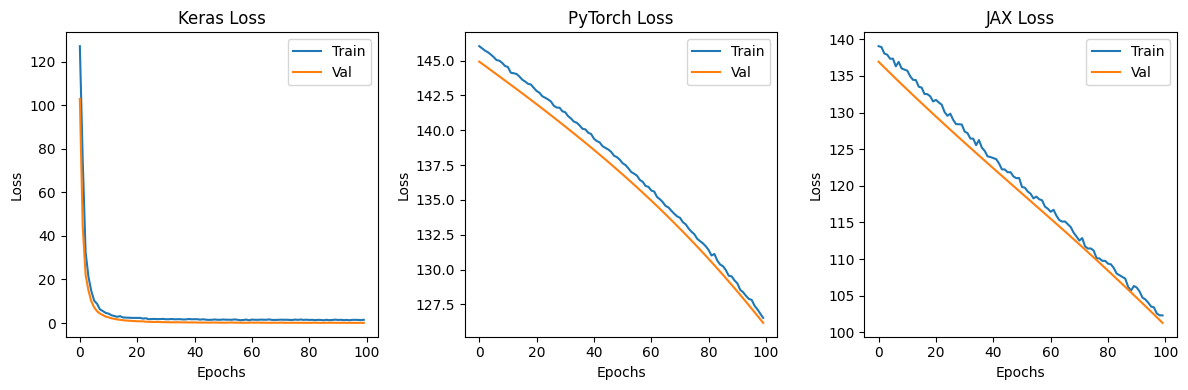

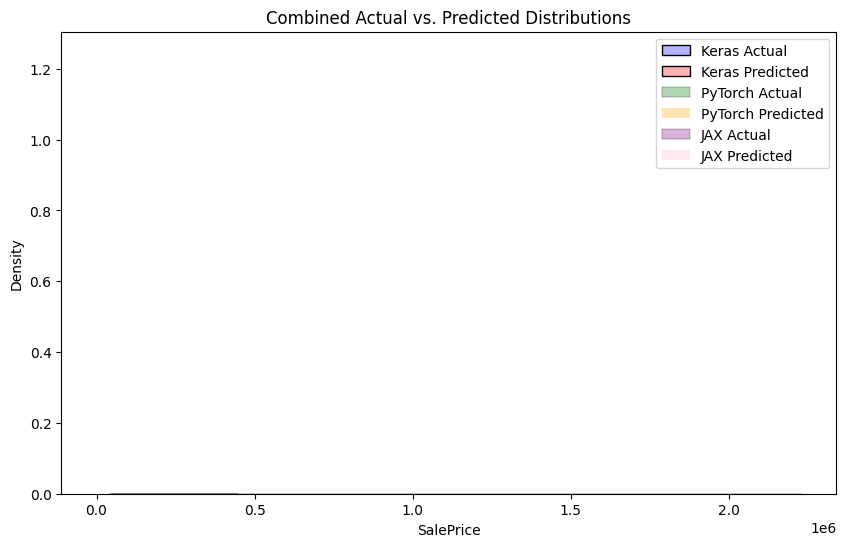

In [28]:
# Print summary RMSE values
print("Keras RMSE:", rmse_keras)
print("PyTorch RMSE:", rmse_torch)
print("JAX RMSE:", rmse_jax_final)

# Plot combined loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.plot(history_keras.history['loss'], label='Train')
plt.plot(history_keras.history['val_loss'], label='Val')
plt.title('Keras Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_losses_pt, label='Train')
plt.plot(val_losses_pt, label='Val')
plt.title('PyTorch Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_losses_jax, label='Train')
plt.plot(val_losses_jax, label='Val')
plt.title('JAX Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Compare distribution histograms on the validation set
plt.figure(figsize=(10,6))
sns.histplot(y_val_actual, bins=50, color='blue', alpha=0.3, stat='density', label='Keras Actual')
sns.histplot(y_val_pred, bins=50, color='red', alpha=0.3, stat='density', label='Keras Predicted')

sns.histplot(y_val_actual_pt, bins=50, color='green', alpha=0.3, stat='density', label='PyTorch Actual')
sns.histplot(val_preds_pt, bins=50, color='orange', alpha=0.3, stat='density', label='PyTorch Predicted')

sns.histplot(y_val_actual_jax, bins=50, color='purple', alpha=0.3, stat='density', label='JAX Actual')
sns.histplot(val_preds_jax, bins=50, color='pink', alpha=0.3, stat='density', label='JAX Predicted')

plt.xlabel('SalePrice')
plt.ylabel('Density')
plt.title('Combined Actual vs. Predicted Distributions')
plt.legend()
plt.show()